# STPB_LSTM_WITH_CLASS

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)
sys.path.append('C:\git\statslib')

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [3]:
import statsmodels.api as sm
import statslib as stb
import tensorflow as tf
import seaborn as sns

In [4]:
import numpy as np
from datetime import datetime, date
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import time
from copy import deepcopy
from pandas.tseries.offsets import DateOffset

In [5]:
from gmt.fom.gas.shared.utils.common import *
from gmt.fom.gas.shared.utils.dframe import *

In [6]:
from gmt.fom.gas.shared.models.short_term_power_burn.stpb import MongoAdapter

In [7]:
figsize=(9*1.6, 9)

In [8]:
def save_to_path(f_name):
    _path = r'C:/git/gmt-fom-gas-research/sandbox/alexs/short_term_power_burn'
    return os.path.join(_path, f_name + '.csv')

In [9]:
def get_fourier_series(timeIndex,K):
    m = 7
    d = 1
    fourier_series = pd.DataFrame({'date':timeIndex})
    fourier_series = fourier_series.set_index(pd.RangeIndex(1,len(timeIndex)+1))

    for i in range(1, K+1):
        fourier_series[f'S{i}-{m}'] = np.sin(2 * i * np.pi * d *fourier_series.index/ m)
        fourier_series[f'C{i}-{m}'] = np.cos(2 * i * np.pi * d *fourier_series.index/ m)
    fourier_series = fourier_series.drop(columns=['date'])
    fourier_series.index = timeIndex
    return fourier_series

# CONSTANTS

In [10]:
YEARS = 3

In [11]:
FORECAST_HORIZON = 1; FORECAST_HORIZON

1

In [12]:
INPUT_WIDTH = 100; INPUT_WIDTH 

100

# DATA

In [13]:
myData = MongoAdapter()
data = myData.load_design_matrix()

2021-04-07 14:52:23,337: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\data_sources\mongo.py: 25: DEBUG: Connected successfully.
2021-04-07 14:52:23,469: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\short_term_power_burn\stpb.py: 88: INFO: Retrieving....


In [14]:
#<------- TRAIN --------- VALIDATION -------- TEST -------->

In [15]:
train_up_to_idx = data.index.min() + DateOffset(years=YEARS)
train_idx = data.truncate(after=train_up_to_idx).index

In [16]:
pred_idx = data.loc[train_up_to_idx+ DateOffset(days=1):].iloc[:-FORECAST_HORIZON].index

In [17]:
out_t_idx = data[-FORECAST_HORIZON:].index

In [18]:
val_idx = sorted(set(data.index).difference(set(train_idx).union(pred_idx).union(out_t_idx)))

In [19]:
print(f'train_idx={len(train_idx)}\nval_idx={len(val_idx)}\npred_idx={len(pred_idx)}\nout_t_idx={len(out_t_idx)}')

train_idx=1097
val_idx=0
pred_idx=772
out_t_idx=1


In [20]:
assert len(train_idx)+len(val_idx)+len(pred_idx)+len(out_t_idx)==data.shape[0]

In [21]:
#Enrich for Design Matrix

In [22]:
#fourier series
K = 3
data = data.join(get_fourier_series(data.index,K))

In [23]:
dependent_var = ['gas']; dependent_var
covariates = ['clean_spreads', 'dark_spreads', 'precip', 'temperature', 'wind']
fourier_cols =  [k for k in data if k.startswith('S') or k.startswith('C')]

In [24]:
y = data[dependent_var]; f = stb.transforms.identical();
gs = dict()
g1 = stb.transforms.identical();
gs.update(dict(zip(covariates, [g1]*len(covariates))))
g2 = stb.transforms.identical()
gs.update(dict(zip(fourier_cols, [g2]*len(fourier_cols))))
X = data[covariates  + fourier_cols ]; 

In [25]:
DM = stb.DesignMatrix(y=y, X=None, f=f, gs=None, add_const=False)

In [26]:
train_df = DM.dm.loc[train_idx].drop('v', axis=1).rename(columns=DM.names)
val_df = DM.dm.loc[val_idx].drop('v', axis=1).rename(columns=DM.names)
pred_df =DM.dm.loc[pred_idx].drop('v', axis=1).rename(columns=DM.names)
out_df =DM.dm.loc[out_t_idx].drop('v', axis=1).rename(columns=DM.names)

In [27]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
pred_df = (pred_df - train_mean) / train_std

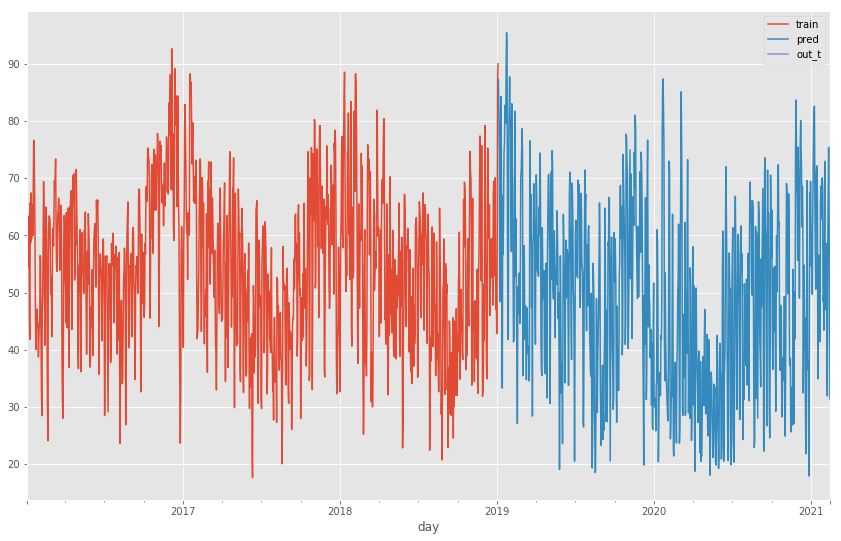

In [28]:
fig, ax = plt.subplots(figsize=figsize)
DM.y.loc[train_idx].plot(ax=ax)
# DM.y.loc[val_idx].plot(ax=ax)
DM.y.loc[pred_idx].plot(ax=ax)
DM.y.loc[out_t_idx].plot(ax=ax)
plt.legend(['train', 'pred', 'out_t'])
plt.show()

# STANDARDIZATION OF FEATURES

In [29]:
train_df.tail(1)

,gas
day,
2019-01-03,2.652855


In [30]:
pred_df.head(1)

,gas
day,
2019-01-04,2.447107


In [31]:
pred_df.tail(1)

,gas
day,
2021-02-13,-1.690671


In [32]:
out_df

,gas
day,
2021-02-14,28.729955


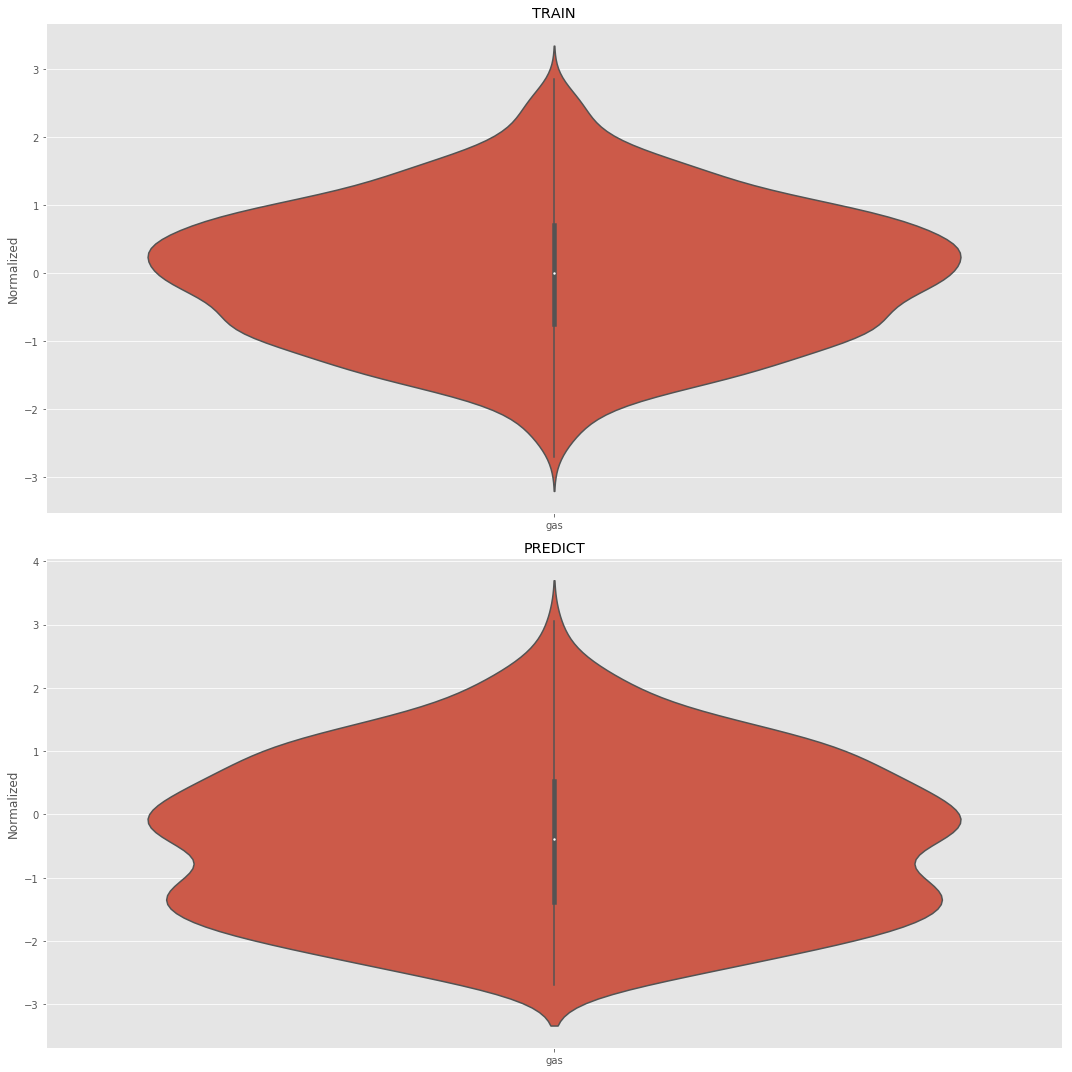

In [33]:
fig, (ax1,ax3) = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
_ = train_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax1)
# _ = val_df.melt(var_name='Column', value_name='Normalized')
# sns.violinplot(x="Column", y="Normalized", data=_, ax=ax2)
_ = pred_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax3)
ax1.set_title('TRAIN')
# ax2.set_title('VALIDATE')
ax3.set_title('PREDICT')
ax1.set_xlabel('')
# ax2.set_xlabel('')
ax3.set_xlabel('')
plt.tight_layout()
plt.show()

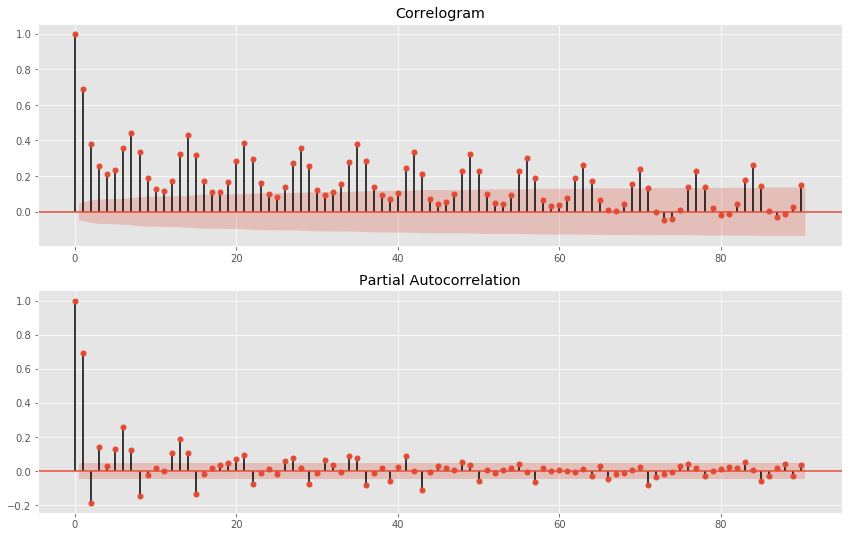

In [34]:
stb.stat_plots.plot_acf_pcf(y, kwargs_acf=dict(lags=90), kwargs_pacf=dict(lags=90))

# WINDOWS GENERATOR

In [35]:
INP_W = 7*2
OUT_W = 7*2
BATC_S = 32
SHUFFLE = False

print(f'INP_W={INP_W} OUT_W={OUT_W} BATC_S={BATC_S} SHUFFLE={SHUFFLE}')

INP_W=14 OUT_W=14 BATC_S=32 SHUFFLE=False


In [36]:
window = stb.WindowGenerator(
                         input_width=INP_W,
                         label_width=OUT_W,
                         shift=OUT_W,
                         train_df=train_df,
                         val_df=None,
                         test_df=pred_df,
                         label_columns=['gas'])

In [37]:
window

Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Label column name(s): ['gas']

In [38]:
window.config(shuffle=SHUFFLE, batch_size=BATC_S)

{'targets': None, 'sequence_stride': 1, 'shuffle': False, 'batch_size': 32}


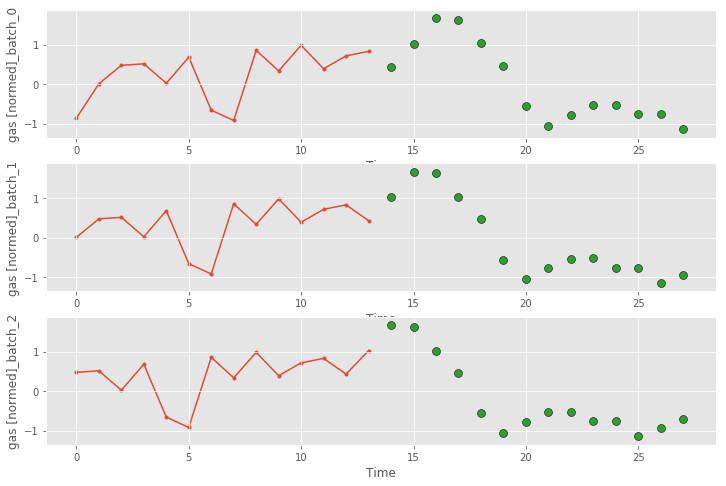

In [39]:
window.plot('gas')

# Long Short Term Memory RNN

In [40]:
lstm_model = tf.keras.models.Sequential([
    
    tf.keras.layers.LSTM(units=BATC_S, activation='relu', return_sequences=False),
#     tf.keras.layers.LSTM(units=64, activation='relu', return_sequences=False),
    tf.keras.layers.Dense(units=OUT_W, 
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_W, 1])
])

In [41]:
print('Input shape (batch_size, input_days, num_features):', window.example[0].shape)
print('Output shape (batch_size, output_days):', lstm_model(window.example[0]).shape)

Input shape (batch_size, input_days, num_features): (32, 14, 1)
Output shape (batch_size, output_days): (32, 14, 1)


In [42]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=4, learning_rate=5e-3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(lr=learning_rate),
                metrics=[tf.metrics.MeanSquaredError()])

  history = model.fit(window.train, 
                      epochs=MAX_EPOCHS,
                      callbacks=[early_stopping])
  return history

In [43]:
history = compile_and_fit(lstm_model,window)

Epoch 1/200
34/34 [==============================] - 1s 4ms/step - loss: 0.8920 - mean_squared_error: 0.8920
Epoch 2/200
34/34 [==============================] - 0s 3ms/step - loss: 0.8430 - mean_squared_error: 0.8430
Epoch 3/200
34/34 [==============================] - 0s 3ms/step - loss: 0.8534 - mean_squared_error: 0.8534
Epoch 4/200
34/34 [==============================] - 0s 3ms/step - loss: 0.8399 - mean_squared_error: 0.8399
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 0.8207 - mean_squared_error: 0.8207
Epoch 6/200
34/34 [==============================] - 0s 3ms/step - loss: 0.7973 - mean_squared_error: 0.7973
Epoch 7/200
34/34 [==============================] - 0s 3ms/step - loss: 0.7876 - mean_squared_error: 0.7876
Epoch 8/200
34/34 [==============================] - 0s 3ms/step - loss: 0.7849 - mean_squared_error: 0.7849
Epoch 9/200
34/34 [==============================] - 0s 4ms/step - loss: 0.7856 - mean_squared_error: 0.7856
Epoch 10/200
34/34 

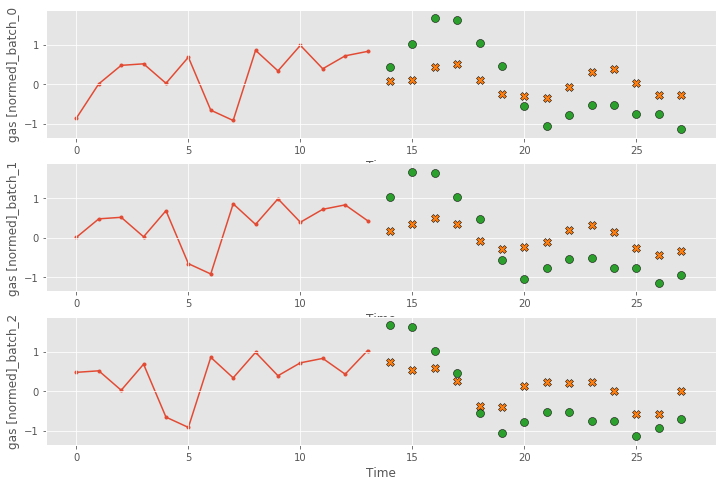

In [44]:
res = window.plot('gas', model=lstm_model)

In [45]:
w_pred = stb.WindowGenerator(
            input_width=INP_W,
            label_width=0,
            shift=0,
            train_df=pred_df.head(INP_W),
            val_df=None,
            test_df=None,
            label_columns=['gas'])

w_pred.config(shuffle=False, batch_size=1)

{'targets': None, 'sequence_stride': 1, 'shuffle': False, 'batch_size': 1}


In [46]:
fl = stb.utils.common.flatten_lst

In [47]:
fl(fl(lstm_model.predict(w_pred.train)))

[1.1726886,
 0.6611739,
 0.41059873,
 0.48349217,
 0.6110414,
 0.7479439,
 0.86464536,
 0.7420162,
 0.42295727,
 0.28231725,
 0.40546128,
 0.5670264,
 0.71895134,
 0.84343183]

In [48]:
fl = stb.utils.common.flatten_lst

In [49]:
idx = pred_df.shift(INP_W).dropna().head(OUT_W).index; idx

DatetimeIndex(['2019-01-18', '2019-01-19', '2019-01-20', '2019-01-21',
               '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25',
               '2019-01-26', '2019-01-27', '2019-01-28', '2019-01-29',
               '2019-01-30', '2019-01-31'],
              dtype='datetime64[ns]', name='day', freq=None)

In [50]:
predicted = fl(fl(lstm_model.predict(w_pred.train))); predicted

[1.1726886,
 0.6611739,
 0.41059873,
 0.48349217,
 0.6110414,
 0.7479439,
 0.86464536,
 0.7420162,
 0.42295727,
 0.28231725,
 0.40546128,
 0.5670264,
 0.71895134,
 0.84343183]

In [51]:
v_hat = pd.Series(predicted, index=idx); v_hat

day
2019-01-18    1.172689
2019-01-19    0.661174
2019-01-20    0.410599
2019-01-21    0.483492
2019-01-22    0.611041
2019-01-23    0.747944
2019-01-24    0.864645
2019-01-25    0.742016
2019-01-26    0.422957
2019-01-27    0.282317
2019-01-28    0.405461
2019-01-29    0.567026
2019-01-30    0.718951
2019-01-31    0.843432
dtype: float64

In [52]:
v = pred_df.loc[idx]['gas']; v

day
2019-01-18    1.625809
2019-01-19    2.115342
2019-01-20    2.082382
2019-01-21    1.878261
2019-01-22    2.669684
2019-01-23    3.055438
2019-01-24    2.841230
2019-01-25    0.453142
2019-01-26   -0.922777
2019-01-27   -0.837413
2019-01-28    1.662372
2019-01-29    2.055643
2019-01-30    2.484459
2019-01-31    2.005918
Name: gas, dtype: float64

In [53]:
y_hat = v_hat*train_std['gas']+train_mean['gas']; y_hat

day
2019-01-18    70.052743
2019-01-19    63.152509
2019-01-20    59.772298
2019-01-21    60.755617
2019-01-22    62.476232
2019-01-23    64.323019
2019-01-24    65.897300
2019-01-25    64.243056
2019-01-26    59.939013
2019-01-27    58.041806
2019-01-28    59.702995
2019-01-29    61.882477
2019-01-30    63.931916
2019-01-31    65.611133
dtype: float64

In [54]:
y = DM.dm.loc[y_hat.index]['gas']; y

day
2019-01-18    76.165250
2019-01-19    82.768959
2019-01-20    82.324332
2019-01-21    79.570774
2019-01-22    90.246923
2019-01-23    95.450664
2019-01-24    92.561043
2019-01-25    60.346198
2019-01-26    41.785316
2019-01-27    42.936860
2019-01-28    76.658477
2019-01-29    81.963631
2019-01-30    87.748273
2019-01-31    81.292850
Name: gas, dtype: float64

In [55]:
print(f'Error={stb.metrics.root_mean_squared_error(y, y_hat):.4f}')

Error=20.3762


In [56]:
metric = stb.metrics.root_mean_squared_error

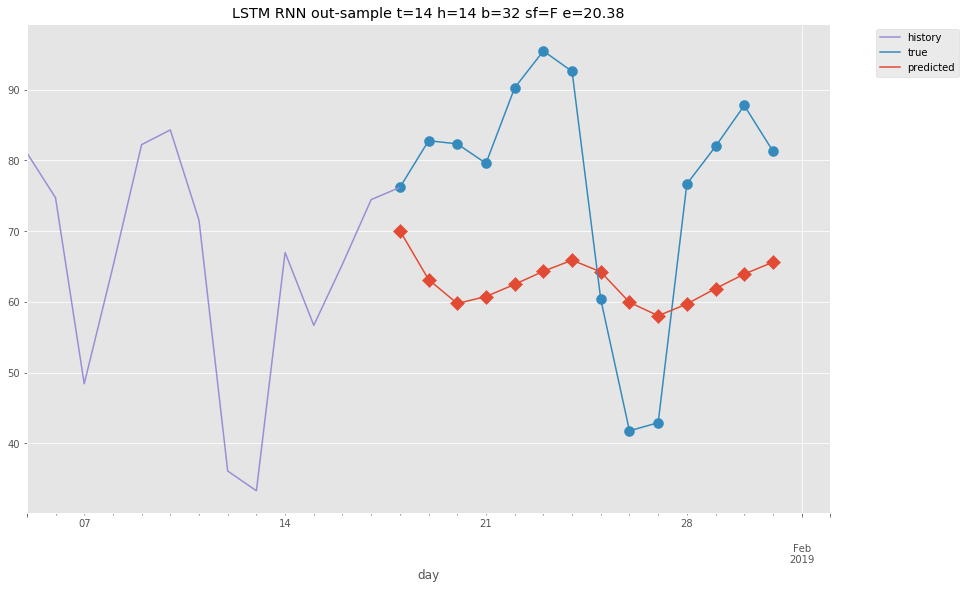

In [57]:
out_of_sample_error = metric(y, y_hat)

fig, ax =plt.subplots(figsize=figsize)
DM.dm.truncate(after=y_hat.index.min()).iloc[-int(INP_W):]['v'].plot(ax=ax, 
                                        color=stb.utils.plots.get_standard_colors()[2])
y.plot(ax=ax, color=stb.utils.plots.get_standard_colors()[1])
y_hat.plot(ax=ax, color=stb.utils.plots.get_standard_colors()[0])

ax.scatter(y.index, y.values, 100, color=stb.utils.plots.get_standard_colors()[1])
ax.scatter(y_hat.index, y_hat.values, 100, marker='D', color=stb.utils.plots.get_standard_colors()[0])


ax.legend(['history', 'true', 'predicted'], bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlim(right=y.index.max() + DateOffset(days=2))

plt.title(f'ForecastHorizon={OUT_W}days | Error={stb.metrics.root_mean_squared_error(y, y_hat):.4f}')
title = f'LSTM RNN out-sample t={OUT_W} h={INP_W} b={BATC_S} sf={str(SHUFFLE)[0]} e={out_of_sample_error:.2f}'
ax.set_title(title)
plt.savefig(r'C:\temp\{}.png'.format(title), bbox_inches = 'tight', pad_inches = 0)
plt.show()